# Discovering topics in speech data using cross-lingual side information

## Fisher Spanish speech dataset

The dataset provides **819 telephone calls** between native Spanish speakers. For each call, the speakers are assigned a topic for discussion. The list of topics, totalling 25, is as follows:
```
Music, Marriage, Religion, Cell phones,  Dating, 
Telemarketing and SPAM, Politics, Travel,  Technical devices, 
Healthcare, Advertisements, Power,  Occupations, Movies, Welfare, 
Breaking up, Location,  Justice, Memories, Crime, 
Violence against women, Equality,  Housing, Immigration
```

The average duration of a phone call is 12 minutes. Though the speakers are allocated only a single topic, the conversations can stray onto different ones after a few minutes into the call. Each call is further divided into a set of utterances, with each utterance only a few seconds long.

The training, development and test set details are as follows:

 
| |# calls | # utterances | Duration (hrs) |
| ---|--- |--------| -----|
| train | 759 | 140K | 160 |
| dev | 20 | 3.9K | 4.5 |
| dev2 | 20 | 3.9K | 4.5 |
| test | 20 | 3.6K | 4.5 |


## Using English translations to determine "topic" being discussed in speech segments

We can infer the topic of a speech segment by analyzing the words in its English translation.

For example, consider the following example where the speaker announces the assigned topic: **marriage**.

It also illustrates the challenge that speakers can go off-topic.

In [85]:
textwrap.wrap(group_text['fisher_train'][20][100:225], width=50)

[" okay ah today's topic is marriage right yes or we",
 'can talk about anything else you want oh okay okay',
 'um in what state are yo']

Large parts of this call however are off-topic, such as the following discussion about tattoos:

In [86]:
textwrap.wrap(group_text['fisher_train'][21][400:800], width=50)

[" was yes yes um what do you what do you do um i'm",
 "working oh i do i do tattoos oh really yes oh i've",
 'wanted to do a do a tattoo since a long time ago',
 'where in the shoulder in the shoulder in the',
 'shoulder yes like in the in the clavicle yes no',
 'the blade the clavicle is in the center the blade',
 'yes but but it scares me no no it hurts me no ah i',
 'have a lot i have i have one in the back one in',
 'the neck']

Let's look at a different call, where the translations indicate that the speakers are discussing: **music**

In [87]:
textwrap.wrap(group_text['fisher_train'][100][310:600], width=50)

['do you listen to music over there ah good since i',
 'have a computer ah i can listen to spanish or',
 'english music aha but i like spanish the most',
 "because it's more romantic mm okay and you well",
 "here there are many hispanics but mm we don't have",
 'a totally spanish station in spanish really somet']

## Proposed method - using Fisher training text to learn a topic model

We propose to learn a topic model using the entire set of human annoted English translations for the Fisher Spanish speech.

Such a model learns the probabilty of a topic, given the words in a document.

For new speech utterances, we first generate the English translations using an ST model, and then use the words in the translations to infer the topic.

To evaluate our model, we compare the topic predicted using ST output to the one predicted using human translations for both dev and test sets.

## Defining a “document”

For topic modeling, we need to define a logical grouping of the input data. As topics are allocated at a call level, using an entire call data as a single document may seem the obvious choice. However, this gives us very few documents to learn topics from, and also to validate them on. If we use utterances instead, then we end up with too many documents; we also don’t expect users to change topics every 5 or 10 seconds. Learning topics from such a fine-level grouping of data may also be difficult.

We therefore group a set of utterances together and use their text for topic modeling. For each call, we divide the total number of utterances into 5 roughly equal parts. This should give us about 2 mins of speech per document.

| |# documents |
| ---| -----|
| train | 3.8K |
| dev | 100 |
| dev2 | 100 |
| test | 100 |


## Input for topic modeling - text processing

We first learn a set of topics using the human annotated training set text. There are a total of 1.5 million word tokens and 17K word types in the text. As we are looking for topics, which are broad level categories, we do not need to use all the 17K word types. To reduce this number, and focus on high importance words, we preprocess the English translations as follows:
1. Lowercase and removing punctuation
2. Remove stopwords
3. Remove frequent words, occurring in more than 25% of the documents
4. Remove infrequent words, occurring in less than 10 documents
5. Keep only the most frequent 1000 words out of the remaining word types
6. Compute tf-idf for each of the 1000 word types in each of the 3.8K documents


## Topic Model: Non-Negative Matrix Factorization (NMF)

We use **NMF** for topic modeling. This is a matrix factorization method, which given a vector V, factorizes it into two matrices: W (long-narrow), and H (short-wide). All three matrices will have non-negative elements, V by design, and W and H by the learning method. 

**document-word TF-IDF matrix V**

For each document, we then create a matrix with the documents as the rows, and the word types as the columns. Each cell represents the tf-idf value of the word in that document

**document-topic matrix W**

The number of columns of the W matrix is equal to the number of topics we want to discover. Though the participants were assigned 25 topics, through trial and error we find out that 10 topics gives us a better output. Therefore, in this work we will focus on 10 latent topics which we will extract using NMF.

**topic-word matrix H**

This row has 10 rows, one for each topic, and the columns indicate the importance of each word for that topic.

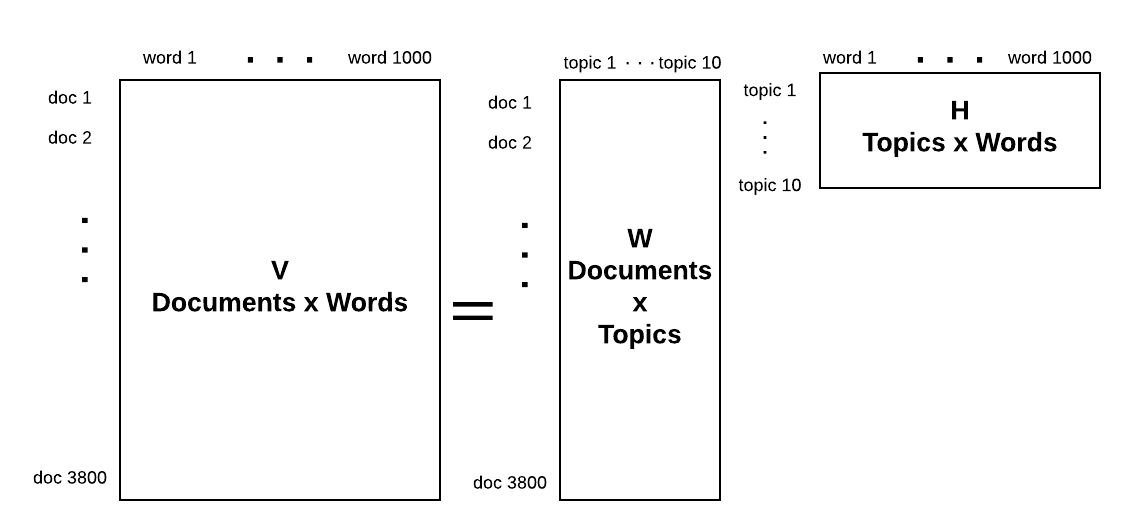

In [88]:
Image("./figs/speech_topic_modeling.png")

## Topics learned using NMF

Using NMF and setting the number of latent topics to 10, we get the following output:

In [111]:
for i, (t,w) in enumerate(nmf_topics.items(), start=1):
    print("{0:2d} | {1:15s}   {2:s}".format(i, nmf_topics_names[t], " ".join(w.split()[:5])))
    print("{0:2s} | {1:15s}   {2:s}".format(" ", " ", " ".join(w.split()[5:10])))
    print("-"*60)

 1 | relationships     married old course kids got
   |                   life someone hard family man
------------------------------------------------------------
 2 | music             music listen dance play songs
   |                   salsa radio listening classical rock
------------------------------------------------------------
 3 | religion          religion church god catholic religions
   |                   believe religious christian different bible
------------------------------------------------------------
 4 | location-cities   hello new york city cold
   |                   philadelphia nice name fine topic
------------------------------------------------------------
 5 | politics-power    united states country power countries
   |                   world government money help president
------------------------------------------------------------
 6 | technology        phone call use computer calls
   |                   cell internet telephone cellular number
-------

## Generating silver labels for evaluation

We now use the trained topic model to generate silver labels for the dev and dev2 sets using their human annotated English translations.

The following table shows the reference topics for a sample of 10 dev set utterances.

**refTopic** : topic with the highest predicted score used as the **silver label**

**refScore** : predicted score, between 0 and 1, with 1 being the highest/most probable

**refWords** : predicted topic related words in the document


In [90]:
cols_to_show = ['refTopic', 'refScore', 'refWords']
# showing the predicted topic for a sample of 10 dev set documents
dev_df[cols_to_show].sample(10)

,refTopic,refScore,refWords
55,politics-power,0.31,world-country-money-politics
15,relationships,0.42,told-course
0,religion,0.39,god-christians-christian-catholic-religion
87,location-cities,0.63,city-cold
89,politics-power,0.42,states-country-government
34,music,0.61,salsa-play-dance-music
4,religion,0.80,god-says-bible-believe-church-christian-religion
8,religion,0.85,says-bible-believe-church-understand-catholic-...
11,religion,0.82,god-religions-believe-catholic-us-religion-rel...
59,relationships,0.56,told-true-got-take


### Topic words can also be used for summarizing speech utterances

As the documents are groupings of utterances from a call and are ordered chronologically, we can also see how the topic evolves over a call.

For example, _document 95_ is the start of the call and we might interpret the topic words as small talk. The call then moves to discussing locations (_document 97_), then family, and finally around housing in .

This indicates that apart from topic modeling, this method can also be used for **summarization**.

In [121]:
cols_to_show = ['refTopic', 'refScore', 'refWords', '20h+asr']
# showing the predicted topic for a sample of 10 dev set documents
dev_df[cols_to_show][95:]

,refTopic,refScore,refWords,20h+asr
95,technology,0.36,talking-call-talk-calling-calls,location-cities
96,technology,0.45,number-phone-email-send-call-calls-computer,location
97,location-cities,0.48,philadelphia-city-university-long,politics-power
98,relationships,0.61,life-hard-family-married-someone-children,housing
99,housing,0.57,apartment-buy-money-house,housing


** Distribution of silver labels **

We count the frequency of each predicted topic.

**relationships** is the most frequently discussed topic as per the human translations

We also compute the statistics for the predicted score, and observe that the mean score is 0.59.

In [91]:
display(train_df['refTopic'].value_counts())
display(train_df['refScore'].describe())
print("# docs with >= 0.5 score for topic in train set: ", len(train_df[train_df['refScore'] >= 0.5]))
print("# docs with >= 0.5 score for topic in dev set: ", len(dev_df[dev_df['refScore'] >= 0.5]))

relationships      1211
location-cities     591
politics-power      355
technology          347
religion            253
housing             253
music               237
healthcare          214
location            169
movies              165
Name: refTopic, dtype: int64

count   3,795.00
mean        0.60
std         0.19
min         0.22
25%         0.45
50%         0.58
75%         0.74
max         1.00
Name: refScore, dtype: float64

# docs with >= 0.5 score for topic in train set:  2522
# docs with >= 0.5 score for topic in dev set:  59


## Using ST output to predict topics

In [92]:
# cols_to_show = ['refTopic', 'refScore', 'Weiss', '50h', '50h+asr', '20h', '20h+asr', '5h', '5h+asr']
cols_to_show = ['refTopic', 'refScore', 'Weiss', '20h', '20h+asr']

**Weiss**    : predicted topic using Google translations

**20h**      : predicted topic using ST model trained on 20hours of Spanish-English data

**20h+asr**  : predicted topic using ST model trained on 20hours of Spanish-English data + English ASR pretraining

In [93]:
dev2_df[cols_to_show].sample(5)

,refTopic,refScore,Weiss,20h,20h+asr
35,technology,0.91,technology,technology,technology
79,technology,0.54,technology,technology,technology
86,politics-power,0.50,relationships,location-cities,relationships
98,location,0.56,location,technology,location
54,location,0.51,location,movies,location


## Computing accuracy

**Baseline** : Models trained using ST data only

**freq**     : Naive baseline where we predict the most common topic in the training set

**+Eng ASR** : Using pretrained ASR models for ST

In [94]:
dev_eval_results = eval_topics(dev_df, dev_pred_topics)

model    |  freq |  2.5h |    5h |   10h |   20h |   50h | Weiss
-----------------------------------------------------------------
baseline |   25% |    8% |   18% |    8% |   50% |   68% |   83%
+Eng ASR | ---   |   36% |   46% |   61% |   65% |   74% | ---  


In [95]:
dev2_eval_results = eval_topics(dev2_df, dev2_pred_topics)

model    |  freq |  2.5h |    5h |   10h |   20h |   50h | Weiss
-----------------------------------------------------------------
baseline |   25% |    6% |   14% |    9% |   61% |   76% |   91%
+Eng ASR | ---   |   25% |   45% |   72% |   79% |   81% | ---  


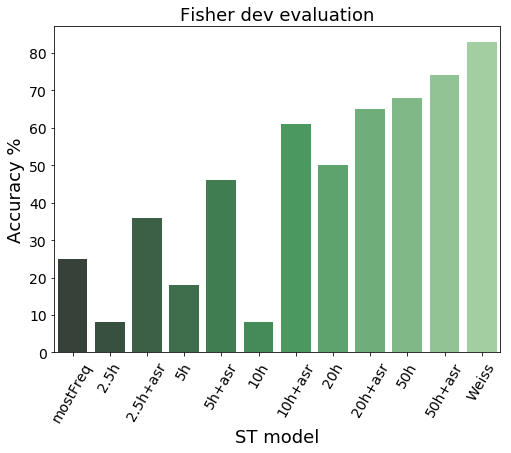

In [96]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.barplot(*zip(*dev_eval_results), palette="Greens_d")
ax.xaxis.set_tick_params(labelsize=14, rotation=60)
ax.yaxis.set_tick_params(labelsize=14)
_ = ax.set_ylabel("Accuracy %", fontsize=18)
_ = ax.set_xlabel("ST model", fontsize=18)
_ = plt.title("Fisher dev evaluation", fontsize=18)

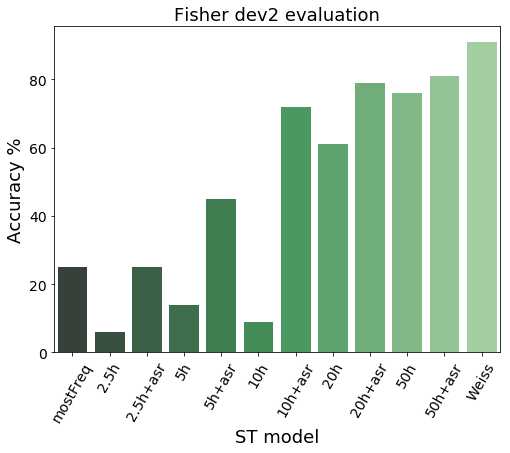

In [97]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.barplot(*zip(*dev2_eval_results), palette="Greens_d")
ax.xaxis.set_tick_params(labelsize=14, rotation=60)
ax.yaxis.set_tick_params(labelsize=14)
_ = ax.set_ylabel("Accuracy %", fontsize=18)
_ = ax.set_xlabel("ST model", fontsize=18)
_ = plt.title("Fisher dev2 evaluation", fontsize=18)

# Main code

https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

In [1]:
from IPython.display import Image, Audio

In [2]:
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine

import textwrap

from sklearn.metrics.pairwise import cosine_similarity

import pickle
import os
import copy
from tqdm import tqdm
import random
import copy

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np
from collections import Counter

from scipy import stats
import scipy.io.wavfile
from IPython.display import Audio
from IPython.display import display

import time

import re
import numpy as np
import pandas as pd
import sklearn
from pprint import pprint

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

%matplotlib inline

In [3]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
# end for


In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')+stopwords.words('spanish')
stop_words.extend(['hmm', 'mm', 'mhm', 'umm', 'umm', 'aha', "uh", "yes", "ah", "um", "eh", "hm"])

In [5]:
len(stop_words)

452

Steps:

1. Train topic model using Fisher train text
2. Predict topic per call for dev set using reference text
3. Predict topic per call for dev set using predicted text

In [6]:
def clean_out_str(out_str):
    out_str = out_str.replace("`", "")
    out_str = out_str.replace('"', '')
    out_str = out_str.replace('¿', '')
    out_str = out_str.replace("''", "")

    # for BPE
    out_str = out_str.replace("@@ ", "")
    out_str = out_str.replace("@@", "")

    out_str = out_str.strip()
    return out_str


# In[46]:


def get_out_str(h, dec_key):
    h = [w.decode() for w in h]
    out_str = ""
    if dec_key == "en_w":
        for w in h:
            out_str += "{0:s}".format(w) if (w.startswith("'") or w=="n't") else " {0:s}".format(w)
    elif "bpe_w" in dec_key:
        out_str = " ".join(h)

    elif dec_key == "en_c":
        out_str = "".join(h)
        
    else:
        out_str = " ".join(h)

    out_str = clean_out_str(out_str)
    return out_str

In [7]:
# def get_call_text(key, dec_key):
#     call_text = {}
#     for utt in map_dict[key]:
#         call_id = utt.split("-",1)[0]
#         if call_id not in call_text:
#             call_text[call_id] = get_out_str(map_dict[key][utt][dec_key], dec_key)
#         else:
#             call_text[call_id] = "{0:s} {1:s}".format(call_text[call_id], 
#                                                       get_out_str(map_dict[key][utt][dec_key], dec_key))
#     return call_text

### Loading Fisher data

In [8]:
map_dict = pickle.load(open("./mfcc_13dim/bpe_map.dict", "rb"))

In [9]:
dec_key = "bpe_w"

In [10]:
# train_calls_text = get_call_text("fisher_train", "bpe_w")

In [11]:
len(map_dict["fisher_dev"])

3979

In [12]:
# segment_name_map = pickle.load(open("./mfcc_13dim/kaldi_segment_map.dict", "rb"))

In [13]:
utts_by_starttime = {}
for cat in map_dict:
    print(cat)
    utts_by_starttime[cat] = {}
    for utt in tqdm(map_dict[cat], ncols=80):
        call_id = utt.rsplit("-",2)[0]
        if call_id not in utts_by_starttime[cat]:
            utts_by_starttime[cat][call_id] = []        
        utts_by_starttime[cat][call_id].append((utt, map_dict[cat][utt]['seg'][0]['start']))

    for call_id in utts_by_starttime[cat]:
        utts_by_starttime[cat][call_id] = sorted(utts_by_starttime[cat][call_id], 
                                                          key=lambda t:t[1])

 26%|████████▎                       | 36066/138819 [00:00<00:00, 360584.69it/s]

fisher_dev
fisher_dev2
fisher_test
fisher_train


100%|█████████████████████████████████| 15080/15080 [00:00<00:00, 442079.65it/s]

callhome_devtest
callhome_evltest
callhome_train


In [14]:
def get_chunk_text(key, utts, dec_key):
    chunk_text = ""
    for utt in utts:
        utt_text = map_dict[key][utt][dec_key] if type(map_dict[key][utt][dec_key]) == list else map_dict[key][utt][dec_key][3]
        chunk_text = "{0:s} {1:s}".format(chunk_text, 
                                                  get_out_str(utt_text, dec_key))
    return chunk_text

In [15]:
NUM_CHUNKS=5
group_utts = {}
group_text = {}

for cat in utts_by_starttime:
    print(cat)
    group_utts[cat] = []
    for call_id in utts_by_starttime[cat]:
        call_chunks = [list(chunk) for chunk in np.array_split([u for u,s in utts_by_starttime[cat][call_id]],NUM_CHUNKS)]
        group_utts[cat].extend(call_chunks)
    group_text[cat]= []
    for chunk in group_utts[cat]:
        if cat in ["fisher_dev", "fisher_train"]:
            group_text[cat].append(get_chunk_text(cat,chunk,dec_key))
        else:
            group_text[cat].append(get_chunk_text(cat,chunk,"en_w"))
        

fisher_dev
fisher_dev2
fisher_test
fisher_train
callhome_devtest
callhome_evltest
callhome_train


In [16]:
len(group_text['fisher_dev'])

100

In [17]:
len(group_utts['fisher_train'])

3795

In [18]:
num_utts_train = [len(utts_by_starttime["fisher_train"][utts]) for utts in utts_by_starttime["fisher_train"]]

In [19]:
call_times = {}
for utt in utts_by_starttime["fisher_train"]:
    call_times[utt] = utts_by_starttime["fisher_train"][utt][-1][1] / 60

In [20]:
np.mean(list(call_times.values()))

11.831032718489238

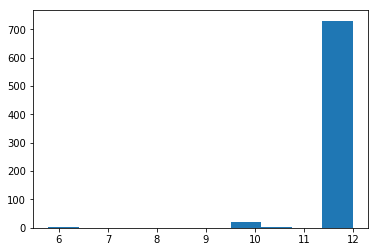

In [21]:
_ = plt.hist(call_times.values())

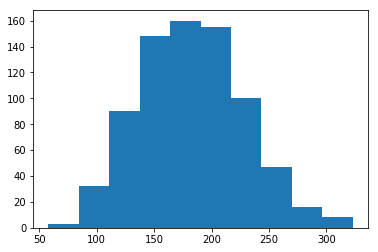

In [22]:
_ = plt.hist(num_utts_train)

In [23]:
train_counter = Counter(" ".join([t.strip() for t in group_text['fisher_train']]).split())

In [24]:
train_counter.most_common(5)

[('the', 55098), ('i', 52158), ('and', 45559), ('that', 37779), ('yes', 35097)]

In [25]:
dev_utts = []
with open("./fisher/fisher_dev/fisher_dev_eval.ids", "r", encoding="utf-8") as in_f:
    for line in in_f:
        dev_utts.append(line.strip())
     # end for
# end with

dev2_utts = []
with open("fisher/fisher_dev2/fisher_dev2_eval.ids", "r", encoding="utf-8") as in_f:
    for u in in_f:
        dev2_utts.append(u.strip())

In [26]:
len(dev_utts), len(dev2_utts)

(3977, 3959)

In [27]:
len(map_dict['fisher_test'])

3641

### Read predictions

In [28]:
google_s2t_hyps_path = os.path.join("../chainer2/speech2text/both_fbank_out/", "google_s2t_hyps.dict")
google_s2t_hyps = pickle.load(open(google_s2t_hyps_path, "rb"))
google_hyp_r0 = google_s2t_hyps['fisher_dev_r0']

In [29]:
model_pred_files = {
    "2.5h": "experiments/nmt_asr/sp-2.5hrs_swbd1-train_nodev_ep25_baseline",
    "2.5h+asr": "experiments/nmt_asr/sp-2.5hrs_swbd1-train_nodev_ep25",
    "5h": "experiments/nmt_asr/sp-5hrs_swbd1-train100k_baseline",
    "5h+asr": "experiments/nmt_asr/sp-5hrs_swbd1-train_nodev_ep25",
    "10h": "experiments/nmt_asr/sp-10hrs_swbd1-train100k_baseline",
    "10h+asr": "experiments/nmt_asr/sp-10hrs_swbd1-train_nodev_ep25_enc-attn-dec",
    "20h": "interspeech_bpe/sp_20hrs_best_bn-nobias_batch-32_buck-n25-w80/",
    "20h+asr": "experiments/nmt_asr/sp-20hrs_swbd1-train-nodev_ep25_enc-attn-dec/",
    "50h": "interspeech_bpe/sp_50hrs_best_bn-nobias_bucks-n25-w80_x0.2/",
    "50h+asr": "experiments/nmt_asr/sp-50hrs_swbd1-train-nodev_ep25/",
#     "160h": "interspeech_bpe/sp_160hrs_cnn-512-9-mfcc-13_drpt-0.3_l2e-4_rnn-3"
}

dev_beam_fname = "fisher_dev_beam_len-norm_min-0_max-300_N-5_K-5_W-0.6.en"
dev2_beam_fname = "fisher_dev2_beam_len-norm_min-0_max-300_N-5_K-5_W-0.6.en"

In [30]:
pred_dev_text = {}
pred_dev2_text = {}
for k, v in model_pred_files.items():
    pred_dev_text[k] = {}
    with open(os.path.join(v,dev_beam_fname), "r", encoding="utf-8") as in_f:
        for i, line in enumerate(in_f):
            pred_dev_text[k][dev_utts[i]] = line.strip()
    
    pred_dev2_text[k] = {}
    with open(os.path.join(v,dev2_beam_fname), "r", encoding="utf-8") as in_f:
        for i, line in enumerate(in_f):
            pred_dev2_text[k][dev2_utts[i]] = line.strip()
#         end for line
#     end with open
# end for

In [31]:
pred_dev_text["Weiss"] = {}
for utt in dev_utts:
    pred_dev_text["Weiss"][utt] = " ".join(google_hyp_r0[utt])

In [32]:
google_dev2 = pickle.load(open("google/google_s2t_dev2_hyps.dict","rb"))
pred_dev2_text["Weiss"] = {}
for utt in dev2_utts:
    pred_dev2_text["Weiss"][utt] = " ".join(google_dev2['fisher_dev_r0'][utt])

In [33]:
len(pred_dev_text['20h']), len(pred_dev2_text['20h']), len(pred_dev_text['Weiss']), len(pred_dev2_text['Weiss'])

(3977, 3959, 3977, 3959)

### Group predicted text into chunks

In [34]:
len([u for utts in group_utts['fisher_dev'] for u in utts])

3979

In [35]:
pred_dev2_text.keys()

dict_keys(['2.5h', '2.5h+asr', '5h', '5h+asr', '10h', '10h+asr', '20h', '20h+asr', '50h', '50h+asr', 'Weiss'])

In [36]:
group_pred_dev = {}
for k in pred_dev_text:
    group_pred_dev[k] = []
    for utts in group_utts['fisher_dev']:
        chunk_text = ''
        for u in utts:
            if u in pred_dev_text[k]:
                chunk_text = "{0:s} {1:s}".format(chunk_text, pred_dev_text[k][u])
        group_pred_dev[k].append(chunk_text)

group_pred_dev2 = {}
for k in pred_dev2_text:
    group_pred_dev2[k] = []
    for utts in group_utts['fisher_dev2']:
        chunk_text = ''
        for u in utts:
            if u in pred_dev2_text[k]:
                chunk_text = "{0:s} {1:s}".format(chunk_text, pred_dev2_text[k][u])
        group_pred_dev2[k].append(chunk_text)

In [37]:
group_text['fisher_dev2'][-10], "-"*80, group_pred_dev2['20h+asr'][-10]

(" hi my name is wendy david hi wendy yes oh how are you well i'm from arizona and you in arizona here is connecticut connecticut yeah i believe i spoke with you before repeat that i believe that i i spoke with you last week oh yes um oh now i remember too i'm sorry yes yes your voice sounds familiar oh yes yeah like yes yes i'm from from texas right oh yes you live in texas i mean i had good memories there how are you it's not of a very good memory oh a little bit not much it's that i haven't talked with many people that may be already i for for uh yes yeah uh i didn't speak to many people regarding the survey oh yes this is already my second time yeah doing this oh really ya oh twice but i've participated in other studies as well oh uhhuh okay but in so you are in arizona how is the climate down there oh this this was uh at times it's difficult to understand you oh yes or hear you yeah oh are you on a cell phone or are you at home oh no i'm in my car now oh in your car ya but i'm arr

In [38]:
[(k,len(group_text[k])) for k in group_text]

[('fisher_dev', 100),
 ('fisher_dev2', 100),
 ('fisher_test', 100),
 ('fisher_train', 3795),
 ('callhome_devtest', 100),
 ('callhome_evltest', 100),
 ('callhome_train', 400)]

### SKLEARN


https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730

https://github.com/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb


http://infolab.stanford.edu/~ullman/mmds/ch11.pdf

In [39]:
from sklearn import decomposition
from scipy import linalg

In [40]:
def display_topics(model, feature_names, no_top_words):
    topics = {}
    print("-"*80)
    print("{0:>2} | {1:s}".format("id", "top {0:d} words".format(no_top_words)))
    print("-"*80)
    for topic_idx, topic in enumerate(model.components_):
#         print("Topic %d:" % (topic_idx))
        top_words = " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
        print("{0:>2d} | {1:s}".format(topic_idx, top_words))
        topics[topic_idx] = top_words
    return topics

In [41]:
n_topics = 10
n_top_words = 20

In [42]:
# data = list(train_calls_text.values())
data = group_text["fisher_train"]

### Features - counts, and tf-idf

In [43]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = stop_words,
                                lowercase = True,
                                max_df = 0.25, 
                                min_df = 10,
                                max_features=1000)
tf = tf_vectorizer.fit_transform(data).todense()
print(tf.shape)
tf_feature_names = tf_vectorizer.get_feature_names()
tf_vocab = np.array(tf_feature_names)
print(len(tf_feature_names))
print(tf_vocab[:10])

(3795, 1000)
1000
['able' 'absolutely' 'abuse' 'abused' 'accent' 'accept' 'according'
 'account' 'actually' 'ads']


In [44]:
tfidf_vectorizer = TfidfVectorizer(strip_accents = 'unicode',
                                stop_words = stop_words,
                                lowercase = True,
                                max_df = 0.25, 
                                min_df = 10,
                                max_features=1000)
tfidf = tfidf_vectorizer.fit_transform(data).todense()
print(tf.shape)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
tfidf_vocab = np.array(tfidf_feature_names)
print(len(tfidf_feature_names))
print(tfidf_vocab[:10])

(3795, 1000)
1000
['able' 'absolutely' 'abuse' 'abused' 'accent' 'accept' 'according'
 'account' 'actually' 'ads']


In [45]:
tf.sum(axis=0)[0,43]

73

In [46]:
tf_feature_names[np.argmin(tf.sum(axis=0))], np.min(tf.sum(axis=0)), np.min(tfidf.sum(axis=0)), tfidf_feature_names[np.argmin(tfidf.sum(axis=0))]

('argentinians', 73, 7.374562122436507, 'merengue')

In [47]:
np.all(tf_vocab == tfidf_vocab)

True

### NMF - Frobenius norm

In [48]:
print("Fitting the NMF model (Frobenius norm) with tf-idf features")
%time nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)

Fitting the NMF model (Frobenius norm) with tf-idf features
CPU times: user 5.44 s, sys: 1.27 s, total: 6.72 s
Wall time: 2.35 s


In [49]:
nmf_topics = display_topics(nmf, tfidf_feature_names, n_top_words)

--------------------------------------------------------------------------------
id | top 20 words
--------------------------------------------------------------------------------
 0 | married old course kids got life someone hard family man children love told true take women girl went huh different
 1 | music listen dance play songs salsa radio listening classical rock hear song kind merengue reggaeton rap type dancing sing love
 2 | religion church god catholic religions believe religious christian different bible christians jewish homosexuality us world respect homosexual everyone understand says
 3 | hello new york city cold philadelphia nice name fine topic hi texas mexico today speaking puerto lived talked long university
 4 | united states country power countries world government money help president iraq american come immigrants war latin role politics mexico panama
 5 | phone call use computer calls cell internet telephone cellular number talk talking cellphone phones called s

### Fisher: List of topics assigned to callers

```
"peace", "Music", "Marriage", "Religion", "Cell phones", 
"Dating", "Telemarketing and SPAM", "Politics", "Travel", 
"Technical devices", "Healthcare", "Advertisements", "Power", 
"Occupations", "Movies", "Welfare", "Breaking up", "Location", 
"Justice", "Memories", "Crime", "Violence against women", "Equality", 
"Housing", "Immigration"
```

In [50]:
nmf_topics_names = {
    0: "relationships",
    1: "music",
    2: "religion",
    3: "location-cities",
    4: "politics-power",
    5: "technology",
    6: "housing",
    7: "location",
    8: "healthcare",
    9: "movies"
}

### NMF - KL divergence

In [51]:
# print("Fitting the NMF model (generalized Kullback-Leibler divergence)")
# %time nmf_kl = NMF(n_components=n_topics, random_state=1, beta_loss='kullback-leibler', \
#                    solver='mu', max_iter=1000, alpha=.1, l1_ratio=.5).fit(tfidf)

In [52]:
# nmf_kl_topics = display_topics(nmf_kl, tfidf_feature_names, n_top_words)

### LDA

In [53]:
print("Fitting LDA models with tf features")
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, \
                                      learning_method='online', \
                                      learning_offset=50., \
                                      random_state=0)
%time lda.fit(tf)

Fitting LDA models with tf features
CPU times: user 10.9 s, sys: 184 ms, total: 11.1 s
Wall time: 11.1 s


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [54]:
lda_topics = display_topics(lda, tf_feature_names, n_top_words)

--------------------------------------------------------------------------------
id | top 20 words
--------------------------------------------------------------------------------
 0 | country states united course money countries world problem true women believe understand life another maybe bad different power someone woman
 1 | five hundred three went year thousand house come dollars came back states since united wow pay last university four ago
 2 | music spanish listen english speak play dance understand latin panama nice hear radio different remember kind country love songs listening
 3 | religion god church believe catholic different religions race white religious black christian understand us bible talk family jewish topic christians
 4 | call talk hello talked told talking day topic fine called calls remember today name first times someone phone ok hi
 5 | phone pay use money buy expensive computer house insurance call internet need true put cell system telephone without health

### Sample predictions

In [55]:
hehe = lda.transform(tf_vectorizer.transform(group_text["fisher_dev"][:2]))
np.sum(hehe, axis=1), hehe.shape

(array([1., 1.]), (2, 10))

In [56]:
hehe = nmf.transform(tfidf_vectorizer.transform(group_text["fisher_dev"][20:21]))
np.sum(hehe, axis=1), hehe.shape, hehe, np.argmax(hehe, axis=1)

(array([0.10305226]),
 (1, 10),
 array([[0.        , 0.        , 0.        , 0.05860573, 0.        ,
         0.03688709, 0.00755944, 0.        , 0.        , 0.        ]]),
 array([3]))

In [57]:
sample_doc = tfidf_vectorizer.transform(group_text["fisher_dev"][20:21]).todense()
sample_doc.shape, nmf.components_.shape

((1, 1000), (10, 1000))

In [58]:
sample_topic = sample_doc @ nmf.components_.T
sample_topic, np.argmax(sample_topic)

(matrix([[0.33824545, 0.05943457, 0.06312202, 1.15350641, 0.06944396,
          0.63650755, 0.30869131, 0.06995264, 0.05921587, 0.04230616]]), 3)

In [59]:
W = nmf.transform(tfidf)

In [60]:
W.shape

(3795, 10)

In [61]:
np.argmax(W[20]), W[20]

(3, array([0.02697718, 0.        , 0.        , 0.08017833, 0.        ,
        0.02447819, 0.        , 0.02229256, 0.        , 0.00396046]))

### Predict topic

In [62]:
def pred_topic(text, features, model, topics, topics_names=None, normalize=False):
    # Transform text into features - e.g. tf or tfidf
    features_transform = features.transform(text)
    # Compute and normalize scores
    pred_scores = model.transform(features_transform)
    if normalize:
        pred_scores = pred_scores / np.sum(pred_scores, axis=1)[:, np.newaxis]
    
    # Store words in text which are also the most frequently occurring in the topic
    topic_words_in_text = []
    pred_topics = []
    pred_topic_prob = []
    for i,chunk in enumerate(text):
        chunk_words = set(chunk.strip().split())
        pred_topic = np.argmax(pred_scores[i])
        if topics_names:
            pred_topics.append(topics_names[pred_topic])
        else:
            pred_topics.append(pred_topic)
        topic_words = set(topics[pred_topic].strip().split())
        topic_words_in_text.append("-".join(topic_words & chunk_words))
        pred_topic_prob.append(pred_scores[i][pred_topic])
    #print(pred_scores, pred_scores.sum(axis=1), np.argmax(pred_scores, axis=1))
    return list(zip(pred_topics, pred_topic_prob, topic_words_in_text))

In [63]:
pred_topic(group_text["fisher_dev"][:2], tf_vectorizer, lda, lda_topics, normalize=False)

[(7, 0.4968447744083819, 'living-long-cold-name'),
 (3,
  0.6017711529180274,
  'god-family-church-believe-christian-christians-catholic-us-religion-religious')]

In [64]:
pred_topic(group_text["fisher_dev"][:2], tfidf_vectorizer, nmf, nmf_topics, nmf_topics_names, normalize=True)

[('religion',
  0.39337701436267386,
  'god-christians-christian-catholic-religion'),
 ('religion',
  0.7532935574933017,
  'god-says-church-believe-christian-christians-catholic-us-religion-religious')]

### Fisher dev set topics

In [65]:
pd.options.display.float_format = '{:,.2f}'.format

In [66]:
len(pred_topic(group_text["fisher_dev"], tfidf_vectorizer, nmf, nmf_topics, normalize=True))

100

In [67]:
train_ref_topics = pred_topic(group_text["fisher_train"], tfidf_vectorizer, 
                            nmf, nmf_topics, nmf_topics_names, normalize=True)

dev_ref_topics = pred_topic(group_text["fisher_dev"], tfidf_vectorizer, 
                            nmf, nmf_topics, nmf_topics_names, normalize=True)

dev2_ref_topics = pred_topic(group_text["fisher_dev2"], tfidf_vectorizer, 
                            nmf, nmf_topics, nmf_topics_names, normalize=True)

In [68]:
train_df = pd.DataFrame(train_ref_topics, columns=["refTopic", "refScore", "refWords"])
dev_df = pd.DataFrame(dev_ref_topics, columns=["refTopic", "refScore", "refWords"])
dev2_df = pd.DataFrame(dev2_ref_topics, columns=["refTopic", "refScore", "refWords"])

In [69]:
train_df.head()

,refTopic,refScore,refWords
0,location-cities,0.92,philadelphia-name-speaking-nice-hello-york-new
1,relationships,0.94,married-old-children-got
2,relationships,0.86,family-kids-different-women-old
3,relationships,0.56,life-went-family-kids-told-different
4,relationships,0.53,life-married-family-love


In [70]:
train_df["refTopic"].value_counts()

relationships      1211
location-cities     591
politics-power      355
technology          347
religion            253
housing             253
music               237
healthcare          214
location            169
movies              165
Name: refTopic, dtype: int64

In [71]:
dev_df.head(10)

,refTopic,refScore,refWords
0,religion,0.39,god-christians-christian-catholic-religion
1,religion,0.75,god-says-church-believe-christian-christians-c...
2,religion,0.48,god-catholic-church
3,relationships,0.67,got-family-kids-take-married-went-old-children
4,religion,0.80,god-says-bible-believe-church-christian-religion
5,religion,0.91,religions-world-believe-catholic-us-religion
6,religion,0.85,says-world-church-believe-us-religion-religious
7,religion,0.69,god-church-believe-christian-christians-cathol...
8,religion,0.85,says-bible-believe-church-understand-catholic-...
9,religion,0.80,god-says-religions-different-church-believe-un...


In [72]:
dev_df["refTopic"].value_counts()

relationships      25
location-cities    17
religion           14
music              14
technology          9
housing             6
politics-power      5
location            4
healthcare          4
movies              2
Name: refTopic, dtype: int64

In [73]:
dev_pred_topics = {}

for m in group_pred_dev:
    dev_pred_topics[m] = pred_topic(group_pred_dev[m], tfidf_vectorizer, 
                                    nmf, nmf_topics, nmf_topics_names, normalize=True)
    
    dev_df[m] = pd.Series([t for t,s,c in dev_pred_topics[m]])

dev2_pred_topics = {}
for m in group_pred_dev2:
    dev2_pred_topics[m] = pred_topic(group_pred_dev2[m], tfidf_vectorizer, 
                                    nmf, nmf_topics, nmf_topics_names, normalize=True)
    dev2_df[m] = pd.Series([t for t,s,c in dev2_pred_topics[m]])


/afs/inf.ed.ac.uk/group/project/lowres/work/miniconda3/envs/chainer3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


### Baselines - random and most frequent topic

In [74]:
# dev_df['mostFreq'] = dev_df["refTopic"].mode()[0]
# dev2_df['mostFreq'] = dev2_df["refTopic"].mode()[0]
dev_df['mostFreq'] = train_df["refTopic"].mode()[0]
dev2_df['mostFreq'] = train_df["refTopic"].mode()[0]

In [75]:
dev_df.head(5)

,refTopic,refScore,refWords,2.5h,2.5h+asr,5h,5h+asr,10h,10h+asr,20h,20h+asr,50h,50h+asr,Weiss,mostFreq
0,religion,0.39,god-christians-christian-catholic-religion,location-cities,location-cities,location-cities,location-cities,location-cities,location-cities,religion,location-cities,location-cities,location-cities,religion,relationships
1,religion,0.75,god-says-church-believe-christian-christians-c...,politics-power,religion,location-cities,religion,politics-power,religion,religion,religion,religion,religion,religion,relationships
2,religion,0.48,god-catholic-church,politics-power,location-cities,location-cities,relationships,politics-power,location-cities,relationships,relationships,religion,relationships,religion,relationships
3,relationships,0.67,got-family-kids-take-married-went-old-children,politics-power,location-cities,technology,relationships,location-cities,location-cities,location-cities,relationships,relationships,relationships,relationships,relationships
4,religion,0.80,god-says-bible-believe-church-christian-religion,politics-power,politics-power,housing,location,politics-power,religion,location,religion,religion,religion,religion,relationships


In [76]:
sklearn.metrics.accuracy_score(dev_df["refTopic"], dev_df['50h'])

0.68

In [77]:
dev_pred_topics.keys()

dict_keys(['2.5h', '2.5h+asr', '5h', '5h+asr', '10h', '10h+asr', '20h', '20h+asr', '50h', '50h+asr', 'Weiss'])

In [78]:
base_model = ['mostFreq']
st_models = ['2.5h', '5h', '10h', '20h', '50h']
st_asr_models = [m+"+asr" for m in st_models]
sota_model = ['Weiss']

In [79]:
def eval_topics(topic_df, pred_text):
    eval_results = []
#     sets_to_eval = ["mostFreq"] + list(pred_text.keys())
#     print("{0:10s} | {1:>10s} | ")
    #print("{0:10s} | {1:10s} | {2:10s}".format("model", "accuracy", "mutual info"))
#     print("{0:10s} | {1:>10s}".format("model", "accuracy"))
#     print("-"*40)
    print("{0:8s} | {1:s}".format("model", " | ".join(["{0:>5s}".format(m) 
                                                        for m in ["freq"]+st_models+sota_model])))
    print("-"*65)
    acc_scores = []
    for s in base_model+st_models+sota_model:
        acc = sklearn.metrics.accuracy_score(topic_df["refTopic"], topic_df[s])*100
        #nmi = sklearn.metrics.normalized_mutual_info_score(topic_df["refTopic"], topic_df[s])
#         eval_results.append((s, acc))
        acc_scores.append(acc)
    
    print("{0:8s} | {1:s}".format("baseline", " | ".join(["{0:>4.0f}%".format(a) 
                                                            for a in acc_scores])))
    
    acc_scores = []
    for s in st_asr_models:
        acc = sklearn.metrics.accuracy_score(topic_df["refTopic"], topic_df[s])*100
        #nmi = sklearn.metrics.normalized_mutual_info_score(topic_df["refTopic"], topic_df[s])
#         eval_results.append((s, acc))
        acc_scores.append(acc)
    
    print("{0:8s} | {1:5s} | {2:s} | {3:5s}".format("+Eng ASR", "---", " | ".join(["{0:>4.0f}%".format(a) 
                                                            for a in acc_scores]), "---"))
    
    acc_scores = []
    for s in (base_model+list(pred_text.keys())):
        acc = sklearn.metrics.accuracy_score(topic_df["refTopic"], topic_df[s])*100
        eval_results.append((s, acc))
    
    return eval_results

In [80]:
dev_eval_results = eval_topics(dev_df, dev_pred_topics)

model    |  freq |  2.5h |    5h |   10h |   20h |   50h | Weiss
-----------------------------------------------------------------
baseline |   25% |    8% |   18% |    8% |   50% |   68% |   83%
+Eng ASR | ---   |   36% |   46% |   61% |   65% |   74% | ---  


In [81]:
dev2_eval_results = eval_topics(dev2_df, dev2_pred_topics)

model    |  freq |  2.5h |    5h |   10h |   20h |   50h | Weiss
-----------------------------------------------------------------
baseline |   25% |    6% |   14% |    9% |   61% |   76% |   91%
+Eng ASR | ---   |   25% |   45% |   72% |   79% |   81% | ---  


<Container object of 12 artists>

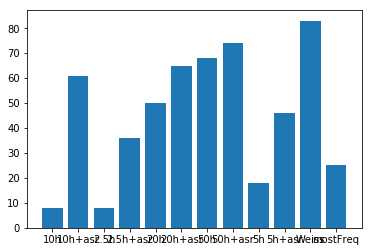

In [82]:
plt.bar(*zip(*dev_eval_results))

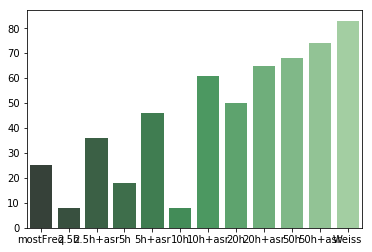

In [83]:
ax = sns.barplot(*zip(*dev_eval_results), palette="Greens_d")

In [84]:
dev2_df.head(20)

,refTopic,refScore,refWords,2.5h,2.5h+asr,5h,5h+asr,10h,10h+asr,20h,20h+asr,50h,50h+asr,Weiss,mostFreq
0,relationships,0.43,got-went-married-course-told,location-cities,location-cities,relationships,location-cities,location-cities,technology,relationships,location-cities,relationships,relationships,relationships,relationships
1,relationships,0.53,life-hard-got-married-children,politics-power,location-cities,location-cities,housing,politics-power,relationships,housing,housing,housing,housing,relationships,relationships
2,relationships,0.74,life-got-went-married-love-children,politics-power,relationships,location-cities,relationships,housing,relationships,relationships,relationships,relationships,relationships,relationships,relationships
3,relationships,0.99,life-got-family-married-course-love,politics-power,housing,location-cities,relationships,politics-power,relationships,relationships,relationships,relationships,relationships,relationships,relationships
4,relationships,0.50,life-true-take-someone,housing,relationships,location,relationships,politics-power,healthcare,housing,healthcare,relationships,relationships,relationships,relationships
5,relationships,0.54,kids-married-true-man-old-children,politics-power,politics-power,housing,location-cities,location-cities,location-cities,location-cities,relationships,relationships,location-cities,relationships,relationships
6,relationships,0.83,take-told-course-women-children,politics-power,relationships,location-cities,relationships,politics-power,politics-power,relationships,relationships,relationships,relationships,relationships,relationships
7,relationships,0.75,course-different-man-women-children,politics-power,technology,location-cities,music,politics-power,relationships,housing,relationships,relationships,relationships,relationships,relationships
8,relationships,0.87,hard-got-kids-married-true-different-love-wome...,politics-power,relationships,relationships,relationships,politics-power,relationships,relationships,relationships,relationships,relationships,relationships,relationships
9,relationships,0.65,take-married-told-true-man-women-children,politics-power,politics-power,location-cities,housing,location-cities,relationships,housing,relationships,housing,relationships,relationships,relationships
